# Notebook for signal generator

In [12]:
import numpy as np
from matplotlib import pyplot as plt
import QAM_codebook as cb
import h5py
#from commpy.filters import rrcosfilter

# setting para
fs = 10000   # sampling rate 
baud = 300  # symbol rate
cf = 1800      # carrier freq
Ns = fs / baud
qams = [4]
ml = 16 * max(qams)

default = True
slices = 1

def generator(q):
    out = []
    arr = np.arange(int(q))
    for i in range(int(ml/q)):
        np.random.shuffle(arr)
        out.extend(arr)
    #np.random.shuffle(arr)
    return out


In [13]:
def rrcosfilter(N, alpha, Ts, Fs):
    """
    Parameters
    ----------
    N : int 
        Length of the filter in samples.
    alpha: float
        Roll off factor (Valid values are [0, 1]).
    Ts : float
        Symbol period in seconds.
    Fs : float 
        Sampling Rate in Hz.
    Returns
    ---------
    h_rrc : 1-D ndarray of floats
        Impulse response of the root raised cosine filter.
    time_idx : 1-D ndarray of floats 
        Array containing the time indices, in seconds, for 
        the impulse response.
    """
    T_delta = 1/float(Fs)
    time_idx = ((np.arange(N)-N/2))*T_delta
    sample_num = np.arange(N)
    h_rrc = np.zeros(N, dtype=float)
    for x in sample_num:
        t = (x-N/2)*T_delta
        if t == 0.0:
            h_rrc[x] = 1.0 - alpha + (4*alpha/np.pi)
        elif alpha != 0 and t == Ts/(4*alpha):
            h_rrc[x] = (alpha/np.sqrt(2))*(((1+2/np.pi)* \
                    (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        elif alpha != 0 and t == -Ts/(4*alpha):
            h_rrc[x] = (alpha/np.sqrt(2))*(((1+2/np.pi)* \
                    (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        else:
            h_rrc[x] = (np.sin(np.pi*t*(1-alpha)/Ts) +  \
                    4*alpha*(t/Ts)*np.cos(np.pi*t*(1+alpha)/Ts))/ \
                    (np.pi*t*(1-(4*alpha*t/Ts)*(4*alpha*t/Ts))/Ts)
    return time_idx, h_rrc

def QAM_(qam):
    Nbits = ml  # number of bits
    N = Nbits * Ns
    code = cb.modulation[qam]
    msg = generator(qam)
    M = []
    for i in range(len(msg)):
        M.append(np.repeat(code[msg[i]],int(Ns)))
    M = np.asarray(M)
    #t = np.r_[0.0:N] / fs
    s = M.flatten()
    #fil = rrcosfilter(s.shape[-1], 1., 1/300, 44100.)[1]
    #s = np.convolve(s, fil, 'full')
    t = np.r_[0.0:s.shape[-1]] / fs
    s = s * np.exp(1j*2*np.pi*float(cf)*t)/np.sqrt(2)/2
    return s.real
    

## for inf SNR.

In [14]:
if default is True:
    QAM = QAM_
else:
    QAM = generate_signal

hf = h5py.File('my_qam_SNR_inf.h5', 'w')

for j in qams:
    out = []
    print (j)
    for f in range(slices):
        s = QAM(j)
        # normalization
        a = s.real
        b = s.imag
        s = s / np.sqrt(np.mean(a**2 + b**2))

        out.append(s)
    # write to hdf5 file
    out = np.asarray(out)
    print (out.shape)
    hf.create_dataset('qam_%d' % j, data=out)
hf.close()
L_ = out.shape[-1]
print (L_)

4
(1, 2112)
2112


## SCD

In [15]:
import numpy as np
import math
import sys
from scipy.fft import fft, fftshift
from scipy import signal


def block_samples(s, window_size, step):
    L = s.shape[-1]
    no = int(np.floor((L - window_size) / step)) + 1
    shape = (no, window_size)
    strides = (s.strides[-1] * step, s.strides[-1])  # size block * window
    return np.lib.stride_tricks.as_strided(s, shape=shape, strides=strides)

def scd(s: np.ndarray, ws: int=64, step: int=0, padding: bool=True, mtd: int=2) -> np.ndarray:
    '''
    I follow the wiki step by step to write this function:
    https://en.wikipedia.org/wiki/Spectral_correlation_density
    '''
    L = s.shape[-1]
    
    if step == 0:
        step = ws // 4
    
    no = int(np.floor((L - ws) / step)) + 1

    if no & (no - 1) != 0 and padding:
        #print ('lenght not enough! padding zero!!')
        Pe = int(np.floor(int(np.log(no)/np.log(2))))
        P = 2**(Pe+1)
        s = np.concatenate((s, np.zeros((int((P-1)*step+ws)-L), dtype=s.dtype)), axis=-1)

    s = block_samples(s, ws, step)
    P = s.shape[0]
    window = signal.windows.hamming(ws)
    window /= np.sqrt(np.sum(window**2))
    s = fftshift(fft(s * window, axis=-1), axes=(-1))
    omega = np.arange(1, (2-ws)/ws, (2-2*ws)/(ws**2))
    suanzi = np.outer(np.arange(P), omega)
    suanzi = np.exp(-1j*np.pi*step*suanzi)

    s = np.multiply(s, suanzi)
    scf = np.einsum('ij,ik->ijk', np.conjugate(s), s)
    
    if mtd == 0:
        return np.abs(np.average(scf, axis=0))

    elif mtd == 1:
        scf = fftshift(fft(scf, axis=0), axes=0)
        return np.abs(np.average(scf, axis=0))
    
    elif mtd == 2:
    ############################
    ####### original FAM #######
    ############################
        scf = fftshift(fft(scf, axis=0), axes=0)
        scf = np.abs(scf)
        Sx = np.zeros((ws, 2*P*step), dtype=float)
        Mp = (P*step)//ws//2
        for k in range(ws):
            for l in range(ws):
                i = int((k+l)/2.0)
                a = int(((k-l)/float(ws)+1.)*P*step)
                Sx[i, a-Mp:a+Mp] = scf[(P//2-Mp):(P//2+Mp),k,l]
        return Sx

In [16]:
hf = h5py.File('my_qam_SNR_inf.h5', 'r+')
nnn = []
name = []

for k in hf.keys():
    o = []
    n, l = hf[k].shape
    print (k)
    o.append(scd_fam(hf[k][0, :2048]))
    nnn.append(o)
    name.append(k)
    
nnn = np.asarray(nnn)
print (nnn.shape)
hf.close()


qam_4
(1, 1, 128, 2048)


In [21]:
nn = nnn.copy()
m = nn[:,0,:,:]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


>>>


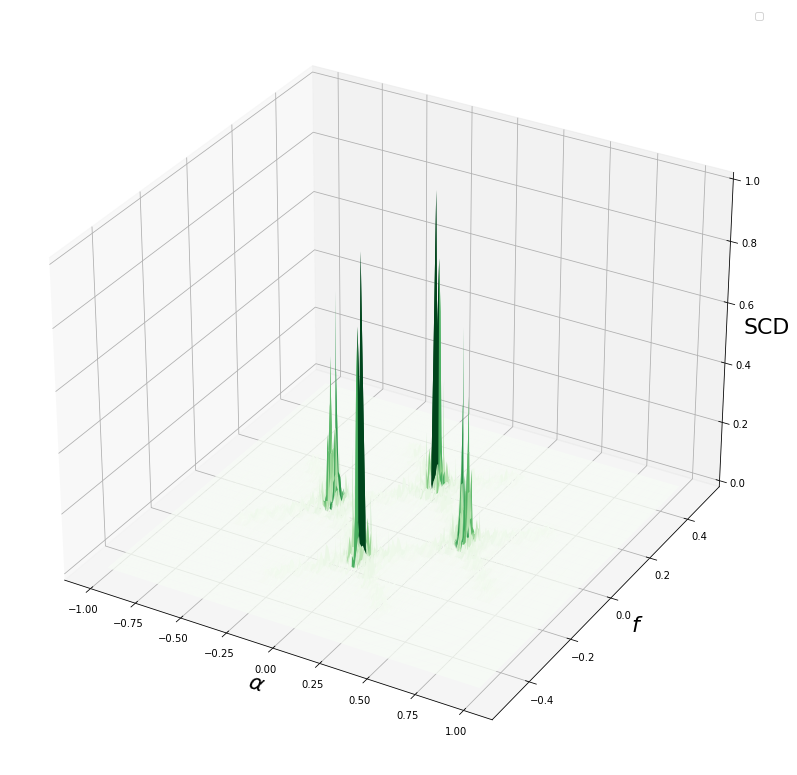

In [22]:
from matplotlib import cm

m = m / np.amax(m, axis=(1,2), keepdims=True)

X = np.linspace(-1., 1., num=int(m.shape[-1]))
Y = np.linspace(-0.5, 0.5, num=int(m.shape[-2]))
X, Y = np.meshgrid(X, Y)

for i in range(m.shape[0]):
    print ('>>>')
    fig = plt.figure(figsize=(14,14))
    ax = fig.add_subplot(111, projection='3d')
    ax.legend()
    ax.set_ylabel(r'$f$', fontsize=22)
    ax.set_xlabel(r'$\alpha$',fontsize=22)
    ax.set_zlabel('SCD',fontsize=22)
    ax.plot_surface(X, Y, m[i,:,:], rstride = 4, cstride = 4, cmap='Greens', antialiased=True)
    #ax.plot_trisurf(X, Y, m[i,:,:], cmap=cm.viridis)
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


>>>


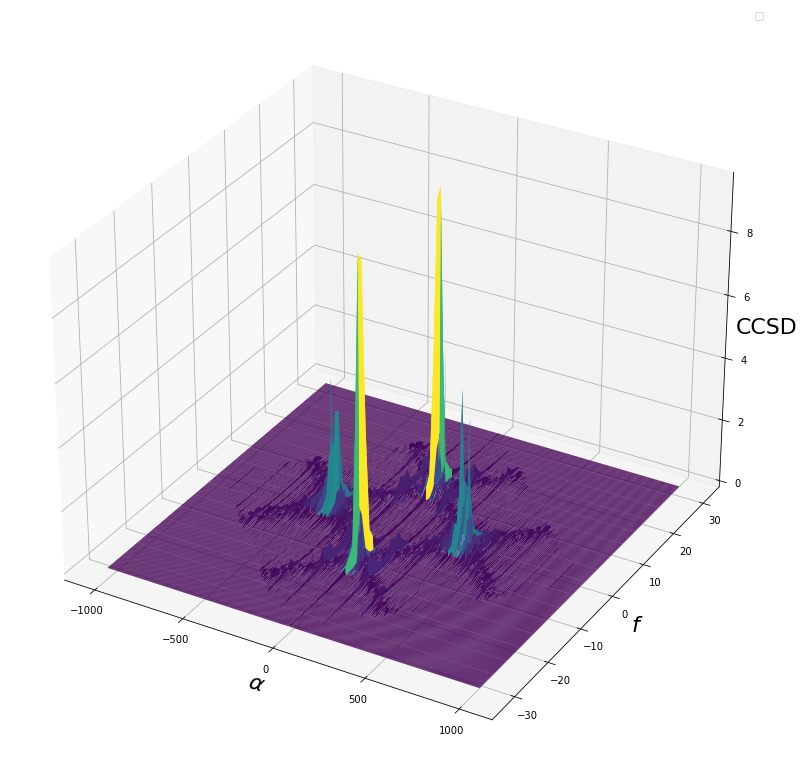

In [91]:
from matplotlib import cm


m = nn[:,0,:,:]

X = np.arange(-m.shape[-1]//2, m.shape[-1]//2)
Y = np.arange(-m.shape[-2]//2, m.shape[-2]//2)
X, Y = np.meshgrid(X, Y)

for i in range(m.shape[0]):
    print ('>>>')
    fig = plt.figure(figsize=(14,14))
    ax = fig.add_subplot(111, projection='3d')
    ax.legend()
    ax.set_ylabel(r'$f$', fontsize=22)
    ax.set_xlabel(r'$\alpha$',fontsize=22)
    ax.set_zlabel('CCSD',fontsize=22)
    ax.plot_surface(X, Y, m[i,:,:], rstride = 4, cstride = 4, cmap=cm.viridis, antialiased=True)
    #ax.plot_trisurf(X, Y, m[i,:,:], cmap=cm.viridis)
    plt.show()